In [ ]:
import numpy as np
import pandas as pd
flist = ['06_23']
data = pd.DataFrame()
first = True
for file in flist:
    if first:
        data = pd.read_pickle('data_6/data_'+file+'.pkl')
        first = False
        with open('data_7/y0_'+file+'.npy', 'rb') as f:
            y = np.load(f)
        with open('data_7/y3_'+file+'.npy', 'rb') as f:
            y3 = np.load(f)
        with open('data_7/y4_'+file+'.npy', 'rb') as f:
            y4 = np.load(f)
    else:
        tmp = pd.read_pickle('data_6/data_'+file+'.pkl')
        data = pd.concat([data, tmp])
        with open('data_7/y0_'+file+'.npy', 'rb') as f:
            tmp = np.load(f)
        y = np.concatenate((y, tmp), axis=0)
        with open('data_7/y3_'+file+'.npy', 'rb') as f:
            tmp = np.load(f)
        y3 = np.concatenate((y3, tmp), axis=0)
        with open('data_7/y4_'+file+'.npy', 'rb') as f:
            tmp = np.load(f)
        y4 = np.concatenate((y4, tmp), axis=0)
data = data.iloc[4:, :]
print(data, data.shape)
print(y, y.shape)

In [10]:
state = 'empty'
total_profit = 0
cnt = 0
takercnt = 0

data['mid_fu'] = data['ap1_fu']/2+data['bp1_fu']/2
data['predict1']=pd.DataFrame(y, index = data.index)
data['stdp2']=pd.DataFrame(y3, index = data.index)
data['stdm2']=pd.DataFrame(y4, index = data.index)

p1='predict1'
p2='predict1'
stp='stdp2'
stm='stdm2'

resl = []
def select(x):
    return (1.5+np.maximum(x,0)/2)*1
def select2(x):
    return (1.5+np.maximum(x,0)/2)*1

lag = 1 # time lag cuz in real trading there will be network lag

for i in range(0, len(data)-1-lag):
    #current_price = data['mid_fu'][i]
    
    if state == 'empty' and (data[p1][i]+data[p2][i])/2 > 0.4:
        buy_price = data['bp1_fu'][i]*(1-select(data[stm][i])/1e4)#*(1-select(data[st][i])*np.maximum(data[stm][i],0.0)/1e4)#-data['fu_efsp'][i]#(current_price)
        tp = data['sellprice_fu'][i+1+lag]
        #print(data['time'][i], buy_price, tp)
        if tp <= buy_price-0.01 and tp != 0:
            #print(data['predict3'][i])
            state = 'buy'
            print(data.index[i],data[p1][i])
            print('buy',i, buy_price, tp, data['buyprice_fu'][i+1], data['mid_fu'][i], data[stp][i], data[stm][i])
        continue
    
    if state == 'empty' and (data[p1][i]+data[p2][i])/2 < -0.4:
        sell_price = data['ap1_fu'][i]*(1+select(data[stp][i])/1e4)#*(1+select(data[st][i])*np.maximum(data[stp][i],0.0)/1e4)
        #+data['fu_efsp'][i]#(current_price)
        tp = data['buyprice_fu'][i+1+lag]
        if tp >= sell_price+0.01 and tp != 0:
            #print(data['predict3'][i])
            state = 'sell'
            print(data.index[i],data[p1][i])
            print('sell',i, sell_price, data['mid_fu'][i], data[stp][i], data[stm][i])
        continue
    
    if state == 'buy' and (data[p1][i]+data[p2][i])/2 < -5:
        sell_price = data['bp1_fu'][i+lag]
        state = 'empty'
        print(data.index[i],data[p1][i])
        print('sell close', sell_price)
        total_profit += sell_price / buy_price - 1
        cnt += 1
        takercnt += 1
        resl.append((data.index[i], total_profit))
        continue
    
    if state == 'sell' and (data[p1][i]+data[p2][i])/2 > 5:
        buy_price = data['ap1_fu'][i+lag]
        state = 'empty'
        print(data.index[i],data[p1][i])
        print('buy close', buy_price)
        total_profit += sell_price / buy_price - 1
        cnt += 1
        takercnt += 1
        resl.append((data.index[i], total_profit))
        continue
    
    if state == 'buy' and (data[p1][i]+data[p2][i])/2 < -np.maximum(0, 0.0):
        sell_price = data['ap1_fu'][i]*(1+select2(data[stp][i])/1e4)#*(1.0+select2(data[st][i])*np.maximum(data[stp][i],0.0)/1e4)#(current_price)
        tp = data['buyprice_fu'][i+1+lag]
        #print(data['time'][i], sell_price, tp)
        if tp >= sell_price+0.01 and tp != 0:
            state = 'empty'
            print(data.index[i],data[p1][i])
            print('sell close', sell_price)
            total_profit += sell_price / buy_price - 1
            cnt += 1
            resl.append((data.index[i], total_profit))
        continue
    
    if state == 'sell' and (data[p1][i]+data[p2][i])/2 > np.maximum(0, 0.0):
        buy_price = data['bp1_fu'][i]*(1-select2(data[stm][i])/1e4)#*(1.0-select2(data[st][i])*np.maximum(data[stm][i],0.0)/1e4)#(current_price)
        tp = data['sellprice_fu'][i+1+lag]
        if tp <= buy_price-0.01 and tp != 0:
            state = 'empty'
            print(data.index[i],data[p1][i])
            print('buy close', buy_price)
            total_profit += sell_price / buy_price - 1
            cnt += 1
            resl.append((data.index[i], total_profit))
        continue
print(total_profit, cnt, takercnt)

2022-06-22 08:15:39.076991 3.2158782168689726
buy 3175 1077.323349752535 1077.260009765625 0.0 1077.715 7.4195492091355675 4.174679625839062
2022-06-22 08:16:02.333683 -5.301769535295264
sell close 1079.46
2022-06-22 08:17:48.926150 -5.985444276044305
sell 4449 1081.5621104972606 1081.205 3.513990297596692 10.45886043165467
2022-06-22 08:17:51.945305 5.006956620565717
buy close 1080.08
2022-06-22 08:19:19.335907 1.0431948109257405
buy 5343 1079.1329723770486 1079.1099853515625 0.0 1079.485 2.5021246378731377 3.4291714154921493
2022-06-22 08:19:22.262444 -5.1877070800721015
sell close 1079.75
2022-06-22 08:22:07.698535 2.391886881936145
buy 6999 1079.592897834524 1079.5699462890625 1080.010009765625 1080.04 6.016744720778178 4.538928990296398
2022-06-22 08:22:39.105578 -5.102427477341465
sell close 1081.05
2022-06-22 08:31:08.318025 -2.6092001008404253
sell 12329 1081.3471537588666 1081.005 3.23757393910995 7.034477167948694
2022-06-22 08:31:59.953718 5.011584604242003
buy close 1080.0


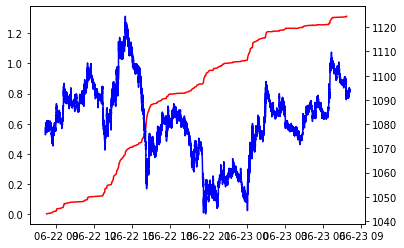

In [11]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(*zip(*resl), color='red')
ax2.plot(data.index, (data['mid_fu']), color='blue')
plt.show()

In [ ]:
CUDA_VISIBLE_DEVICES=1  python main_cnnlstm.py --lr 0.0001 --dropout 0 --opt adamw --x xnn --y 0 --input_size 57 --wd 0.4 --T 5 --batch_size 2048 --old 8 --train "05_24-05_29;05_31-06_06;06_08-06_13;06_15-06_20;06_22-06_27" --test "05_30-05_30;06_07-06_07;06_14-06_14;06_21-06_21" --arch CNNLSTM --dim_lstm 256 --val_split 0.001 --use_p23 3 --min_mean --div_std 

CUDA_VISIBLE_DEVICES=2  python main_cnnlstm.py --lr 0.0001 --dropout 0 --opt adamw --x xnn --y 3 --input_size 57 --wd 0.4 --T 5 --batch_size 2048 --old 8 --train "05_24-05_29;05_31-06_06;06_08-06_13;06_15-06_20;06_22-06_27" --test "05_30-05_30;06_07-06_07;06_14-06_14;06_21-06_21" --arch CNNLSTM --dim_lstm 256 --val_split 0.001 --use_p23 3 --min_mean --div_std 

CUDA_VISIBLE_DEVICES=0  python main_cnnlstm.py --lr 0.0001 --dropout 0 --opt adamw --x xnn --y 4 --input_size 57 --wd 0.4 --T 5 --batch_size 2048 --old 8 --train "05_24-05_29;05_31-06_06;06_08-06_13;06_15-06_20;06_22-06_27" --test "05_30-05_30;06_07-06_07;06_14-06_14;06_21-06_21" --arch CNNLSTM --dim_lstm 256 --val_split 0.001 --use_p23 3 --min_mean --div_std

